In [1]:
! pip install simpy

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import simpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

# 设置输出格式，以显示所有行和列
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 初始化模拟环境和顾客到达过程
def setup(env, num_servers, servicetime, Lambda, waiting_times):
    # 生成服务器资源
    server = simpy.Resource(env, num_servers)

    def service(customer):
        """服务过程使用指数分布的服务时间"""
        yield env.timeout(np.random.exponential(servicetime))

    def customer(name):
        """顾客到达和服务过程"""
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            # 记录每个顾客的等待时间
            waiting_times.append(waiting_time)
    
    # 生成初始顾客
    env.process(customer('Customer 0'))

    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

# 运行模拟函数
def run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # 到达率
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings



In [4]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          1.080654   
1             2  0.10          0.975977   
2             4  0.10          1.005816   
3             1  0.50          1.998980   
4             2  0.50          1.315733   
5             4  0.50          1.060937   
6             1  0.90          4.934402   
7             2  0.90          3.711317   
8             4  0.90          2.249165   
9             1  0.99          6.844037   
10            2  0.99          4.431230   
11            4  0.99          3.696195   

                                     all_waiting_time  \
0   [[0.17740539865014757, 0.3295320430234545, 0.9...   
1   [[0.861631609184445, 0.13912948990167617, 0.35...   
2   [[2.3038503883601607, 1.7042792639332403, 0.80...   
3   [[0.28602306328749544, 0.45464764371256355, 0....   
4   [[0.0765074660071361, 0.47124748737986966, 1.5...   
5   [[0.2655669071750033, 0.48301075448915776, 0.0...   
6   [[0.8002231060449676, 0.7105017383353

In [3]:
# 画ρ影响平均等待时间的图

def run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

def prepare_plot_data(simulation_results, server_configs):
    plot_data = {'rho': [], 'avg_waiting_time': [], 'num_servers': []}
    
    for num_servers, all_waiting_times in zip(server_configs, simulation_results):
        for rho, waiting_times in all_waiting_times.items():
            plot_data['rho'].extend([rho] * len(waiting_times))
            plot_data['avg_waiting_time'].extend(waiting_times)
            plot_data['num_servers'].extend([str(num_servers)] * len(waiting_times))
    
    return pd.DataFrame(plot_data)

def plot_data(df):
    sns.lineplot(data=df, x='rho', y='avg_waiting_time', hue='num_servers')
    plt.title('Comparison of Average Waiting Time by System Load')
    plt.xlabel('System Load (rho)')
    plt.ylabel('Average Waiting Time')
    plt.legend(title='Number of Servers')
    plt.show()


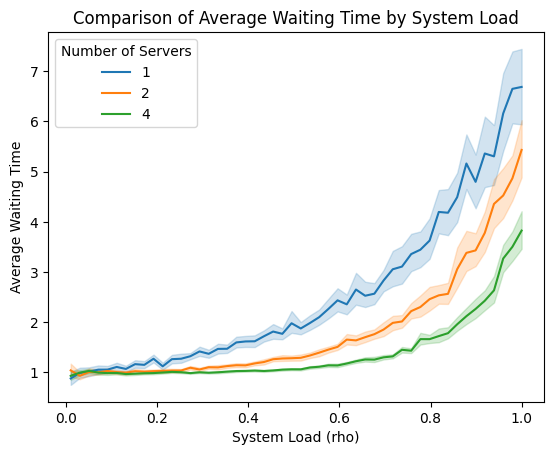

In [8]:
# 定义参数
SIM_TIME = 100
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 50)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


In [9]:
print(all_sim_data[0]['all_waiting_time'][1])

[0.6692792128196248, 0.10449676951007447, 0.4554013481097172, 0.31462764436598434, 3.068114137322212, 2.2518531910125716, 2.1240614289149704, 0.9080987114871135, 2.306594911130162]


In [4]:
# 绘制直方图或密度图
def plt_distribution(all_sim_data, title, xlabel = 'Waiting Time'):
#     print(len(all_sim_data))
#     sns.histplot(all_sim_data, kde=True, element='step', stat='density', bins=200)
    sns.histplot(all_sim_data, kde=True, stat='density', bins=200)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.show()
    
# # 旧的绘制叠加的直方图或密度图
# def plt_distribution_group(sim_data_group, title, labels, xlabel = 'Waiting Time'):
# #     print(len(all_sim_data))
#     for group_data in sim_data_group:
#         sns.histplot(group_data, kde=True, stat='density', bins=200)
# #         sns.histplot(group_data, kde=True, element='step', stat='density', bins=200)

#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel('Density')
#     plt.legend(labels=labels)
#     plt.show()
    
# # 绘制叠加的直方图或密度图
# def plot_distribution_group(sim_data_group, title, labels, xlabel='Waiting Time'):
#     for group_data, label in zip(sim_data_group, labels):
#         sns.histplot(group_data, kde=True, stat='density', bins=200, label=label)

#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel('Density')
#     plt.legend()
#     plt.show()

# 绘制叠加的直方图或密度图
def plt_distribution_group(sim_data_group, title, labels, xlabel='Average Waiting Time'):
    for group_data, label in zip(sim_data_group, labels):
        sns.histplot(group_data, kde=True, stat='density', bins=200, label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def prepare_group_data(sim_data):
    # 将模拟结果中的所有等待时间整理到一个列表中
    all_waiting_times = []
    for data in sim_data:
        all_waiting_times.extend(data)

    return all_waiting_times


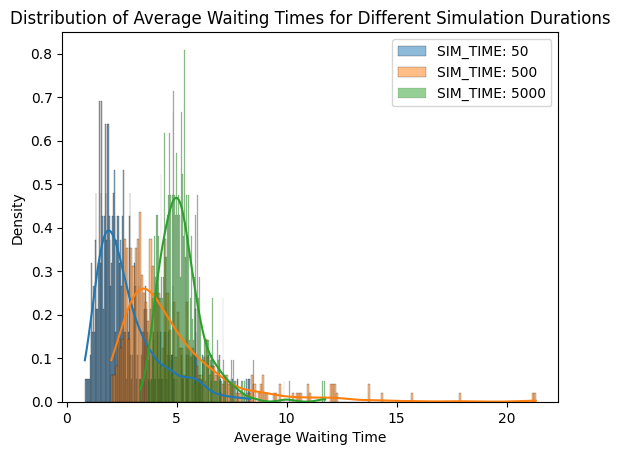

In [11]:
# 定义模拟参数
num_servers = 2  # 服务器数量
rho = 0.9  # 系统负载
MU = 1  # 服务率
SIMULATIONS = 500  # 模拟次数
SIM_TIMES = [50, 500, 5000]  # 不同的模拟时长

# 运行模拟并收集结果
simulation_results = []
for SIM_TIME in SIM_TIMES:
    _, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)
    simulation_results.append(avg_waitings)

# 定义标签
labels = [f'SIM_TIME: {SIM_TIME}' for SIM_TIME in SIM_TIMES]

# 绘制结果
plt_distribution_group(simulation_results, "Distribution of Average Waiting Times for Different Simulation Durations", labels)


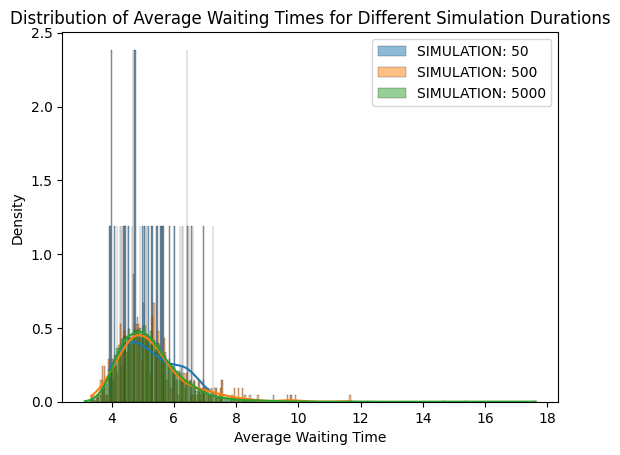

In [12]:
# 定义模拟参数
num_servers = 2  # 服务器数量
rho = 0.9  # 系统负载
MU = 1  # 服务率
SIMULATIONS = [50, 500, 5000]  # 不同的模拟时长
SIM_TIMES = 500  # 模拟时长

# 运行模拟并收集结果
simulation_results = []
for SIMULATION in SIMULATIONS:
    _, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATION)
    simulation_results.append(avg_waitings)

# 定义标签
labels = [f'SIMULATION: {SIMULATION}' for SIMULATION in SIMULATIONS]

# 绘制结果
plt_distribution_group(simulation_results, "Distribution of Average Waiting Times for Different Simulation Durations", labels)


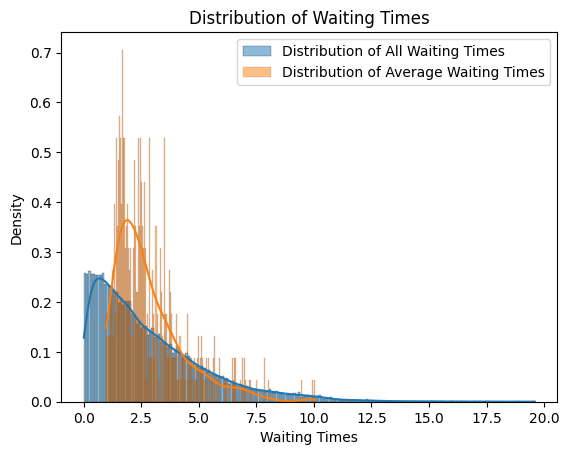

In [13]:
# Simulation parameters
num_servers = 2
rho = 0.9  # System load
MU = 1  # Service rate
SIM_TIME = 50  # Simulation duration
SIMULATIONS = 500  # Number of simulations


sim_data, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual

all_waiting_times = []
for data in sim_data:
    all_waiting_times.extend(data)

# plt_distribution(all_waiting_times, 'Distribution of All Waiting Times')
# plt_distribution(avg_waitings, 'Distribution of Average Waiting Times')
group_data = [all_waiting_times, avg_waitings]
labels = ['Distribution of All Waiting Times', 'Distribution of Average Waiting Times']
plt_distribution_group(group_data, "Distribution of Waiting Times", labels, "Waiting Times")

In [5]:
from scipy import stats

def perform_anova(*data_groups):
    """
    Perform ANOVA test on multiple groups of data.
    
    :param data_groups: Variable number of arrays, each representing a group of data.
    :return: ANOVA test result.
    """
    return stats.f_oneway(*data_groups)


In [99]:
# 模拟参数
num_servers_options = [1, 2, 4]  # 例如，考虑1、2和4个服务器
rho = 0.9  # 系统负载
MU = 1  # 服务率
SIM_TIME = 50  # 模拟时长
SIMULATIONS = 10  # 模拟次数

# 运行模拟并收集平均等待时间
avg_waiting_times_by_server = {}
for num_servers in num_servers_options:
    _, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)
    avg_waiting_times_by_server[num_servers] = avg_waitings

# 调用ANOVA检验函数
anova_result = perform_anova(*avg_waiting_times_by_server.values())

# 输出ANOVA检验结果
print("ANOVA Test Result:", anova_result)


ANOVA Test Result: F_onewayResult(statistic=2.595253020963093, pvalue=0.09312911220867932)


In [100]:
from scipy.stats import f_oneway

def perform_anova(*data_groups):
    """ Perform ANOVA test on multiple groups of data. """
    f_statistic, p_value = f_oneway(*data_groups)
    return f_statistic, p_value


In [112]:
# 模拟参数
SIM_TIME = 100
SIMULATIONS = 4
MU = 1
rho = 0.9

# 运行模拟
# avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
# avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
# avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

_, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
_, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
_, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

# 进行ANOVA检验
f_statistic, p_value = perform_anova(avg_waitings_1_server, avg_waitings_2_servers, avg_waitings_4_servers)

print("ANOVA Test Results:")
print("F-Statistic:", f_statistic)
print("P-Value:", p_value)


ANOVA Test Results:
F-Statistic: 5.3252859756138
P-Value: 0.029778506511771868


In [115]:
from scipy.stats import mannwhitneyu

def perform_mann_whitney_u_test(data1, data2):
    """ Perform Mann-Whitney U test between two groups of data. """
    u_statistic, p_value = mannwhitneyu(data1, data2, alternative='less')
    return u_statistic, p_value

# 进行Mann-Whitney U检验
u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)

print("Mann-Whitney U Test Results:")
print("4 servers vs 2 servers: U-Statistic:", u_stat_4_vs_2, "P-Value:", p_4_vs_2)
print("2 servers vs 1 server: U-Statistic:", u_stat_2_vs_1, "P-Value:", p_2_vs_1)


Mann-Whitney U Test Results:
4 servers vs 2 servers: U-Statistic: 0.0 P-Value: 0.014285714285714285
2 servers vs 1 server: U-Statistic: 2.0 P-Value: 0.05714285714285714


In [116]:
from scipy.stats import mannwhitneyu

def perform_mann_whitney_u_test(data1, data2):
    """Perform Mann-Whitney U test between two groups of data."""
    u_statistic, p_value = mannwhitneyu(data1, data2, alternative='less')
    return u_statistic, p_value


In [256]:
# 模拟参数
SIM_TIME = 50
SIMULATIONS = 30
MU = 1
rho = 0.99

# 运行模拟并收集数据
# avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
# avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
# avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

_, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
_, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
_, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

# print(avg_waitings_1_server)
# print(avg_waitings_2_servers)
# print(avg_waitings_4_servers)

# 进行Mann-Whitney U检验
u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)

print("Mann-Whitney U Test Results:")
print("4 servers vs 2 servers: U-Statistic:", u_stat_4_vs_2, "P-Value:", p_4_vs_2)
print("2 servers vs 1 server: U-Statistic:", u_stat_2_vs_1, "P-Value:", p_2_vs_1)


Mann-Whitney U Test Results:
4 servers vs 2 servers: U-Statistic: 347.0 P-Value: 0.06483511245414082
2 servers vs 1 server: U-Statistic: 325.0 P-Value: 0.03283562884456329


In [291]:
# 模拟参数
SIM_TIME = 50
SIMULATIONS = 120
MU = 1
rho = 0.5

p_4_vs_2_list = []
p_2_vs_1_list = []
for _ in range(10):
    # 运行模拟并收集数据
    # avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
    # avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
    # avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

    _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
    _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
    _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

    # print(avg_waitings_1_server)
    # print(avg_waitings_2_servers)
    # print(avg_waitings_4_servers)

    # 进行Mann-Whitney U检验
    u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
    u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)
    
    p_4_vs_2_list.append(p_4_vs_2)
    p_2_vs_1_list.append(p_2_vs_1)
    
p_4_vs_2_mean = np.mean(p_4_vs_2_list)
p_2_vs_1_mean = np.mean(p_2_vs_1_list)

print("Mann-Whitney U Test Results:")
print("4 servers vs 2 servers: U-Statistic:", u_stat_4_vs_2, "P-Value-Mean:", p_4_vs_2_mean)
print("2 servers vs 1 server: U-Statistic:", u_stat_2_vs_1, "P-Value-Mean:", p_2_vs_1_mean)





Mann-Whitney U Test Results:
4 servers vs 2 servers: U-Statistic: 4914.0 P-Value-Mean: 2.1517495838544767e-06
2 servers vs 1 server: U-Statistic: 3347.0 P-Value-Mean: 4.125783906387847e-08


############  rho = 0.5
SIMULATIONS = 20
0.038278636943027335 0.019856530299289892
############  rho = 0.5544444444444444
SIMULATIONS = 20
0.030754647717914273 0.03758753634570929
############  rho = 0.6088888888888889
SIMULATIONS = 20
0.04329828596929164 0.011739720808901438
############  rho = 0.6633333333333333
SIMULATIONS = 20
0.030795213682276612 0.0593692156015422
SIMULATIONS = 21
0.018025647764540503 0.04461852053478923
############  rho = 0.7177777777777777
SIMULATIONS = 20
0.04416193024864022 0.0543357614054512
SIMULATIONS = 21
0.025190547824456434 0.05081592457309473
SIMULATIONS = 22
0.03934400063173306 0.053915713130478896
SIMULATIONS = 23
0.02251187193415869 0.07624500608709893
SIMULATIONS = 24
0.017909099179705075 0.02254624765830657
############  rho = 0.7722222222222221
SIMULATIONS = 20
0.05228842490052895 0.03747358919307221
SIMULATIONS = 21
0.0377669788921786 0.03857047184927016
############  rho = 0.8266666666666667
SIMULATIONS = 20
0.0425694908946528 0.04596110982768

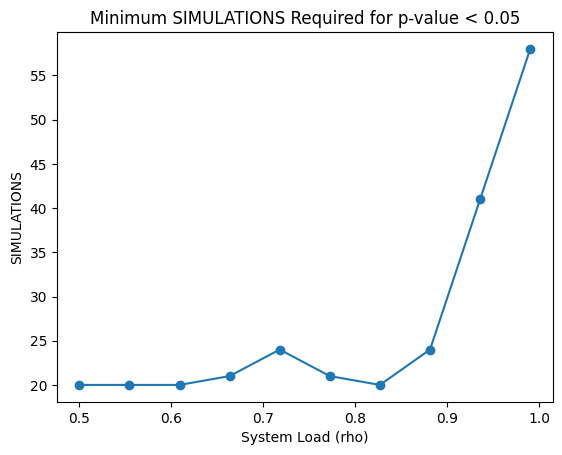

In [300]:
def simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS):
    p_4_vs_2_list = []
    p_2_vs_1_list = []
    for _ in range(20):
        # 运行模拟并收集数据
        # avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        # print(avg_waitings_1_server)
        # print(avg_waitings_2_servers)
        # print(avg_waitings_4_servers)

        # 进行Mann-Whitney U检验
        u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
        u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)
#         print(p_4_vs_2, p_2_vs_1)

        p_4_vs_2_list.append(p_4_vs_2)
        p_2_vs_1_list.append(p_2_vs_1)
    
    p_4_vs_2_mean = np.mean(p_4_vs_2_list)
    p_2_vs_1_mean = np.mean(p_2_vs_1_list)

    return p_4_vs_2_mean, p_2_vs_1_mean

SIM_TIME = 50
MU = 1
rhos = np.linspace(0.5, 0.99, 10)
simulation_results = []

for rho in rhos:
    SIMULATIONS = 20
    print(f"############  rho = {rho}")
    while True:
        print(f"SIMULATIONS = {SIMULATIONS}")
        p_4_vs_2_mean, p_2_vs_1_mean = simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS)
        print(p_4_vs_2_mean, p_2_vs_1_mean)
        if p_4_vs_2_mean < 0.05 and p_2_vs_1_mean < 0.05:
            break
        SIMULATIONS += 1
    simulation_results.append((rho, SIMULATIONS))

# 绘制图表
rhos, sims = zip(*simulation_results)
plt.plot(rhos, sims, marker='o')
plt.title("Minimum SIMULATIONS Required for p-value < 0.05")
plt.xlabel("System Load (rho)")
plt.ylabel("SIMULATIONS")
plt.show()


############  rho = 0.5
SIMULATIONS = 20
0.05596037675894031 0.043945766233096185
SIMULATIONS = 21
0.0598558933630615 0.07927635102631926
SIMULATIONS = 22
0.027212230362563865 0.02654267059642267
############  rho = 0.5544444444444444
SIMULATIONS = 20
0.0446368436987851 0.030549943181571317
############  rho = 0.6088888888888889
SIMULATIONS = 20
0.01893196301986455 0.03858983013448532
############  rho = 0.6633333333333333
SIMULATIONS = 20
0.018735879766054963 0.03979224440764166
############  rho = 0.7177777777777777
SIMULATIONS = 20
0.017610101654022374 0.05471891745907511
SIMULATIONS = 21
0.018502952851313956 0.043482952767477295
############  rho = 0.7722222222222221
SIMULATIONS = 20
0.03823292465360487 0.025270975990886152
############  rho = 0.8266666666666667
SIMULATIONS = 20
0.04166806810012226 0.07055458340124685
SIMULATIONS = 21
0.01895133456347116 0.08797133239746249
SIMULATIONS = 22
0.06036844485904476 0.1045685781667924
SIMULATIONS = 23
0.015684777338198393 0.0645859279387

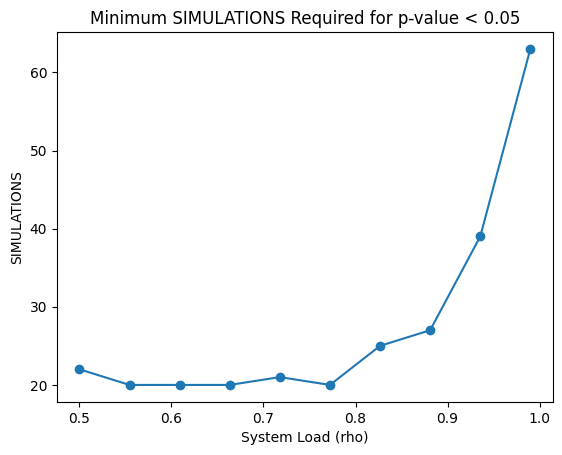

In [302]:
def simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS):
    p_4_vs_2_list = []
    p_2_vs_1_list = []
    for _ in range(20):
        # 运行模拟并收集数据
        # avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        # print(avg_waitings_1_server)
        # print(avg_waitings_2_servers)
        # print(avg_waitings_4_servers)

        # 进行Mann-Whitney U检验
        u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
        u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)
#         print(p_4_vs_2, p_2_vs_1)

        p_4_vs_2_list.append(p_4_vs_2)
        p_2_vs_1_list.append(p_2_vs_1)
    
    p_4_vs_2_mean = np.mean(p_4_vs_2_list)
    p_2_vs_1_mean = np.mean(p_2_vs_1_list)

    return p_4_vs_2_mean, p_2_vs_1_mean

SIM_TIME = 50
MU = 1
rhos = np.linspace(0.5, 0.99, 10)
simulation_results = []

for rho in rhos:
    SIMULATIONS = 20
    print(f"############  rho = {rho}")
    while True:
        print(f"SIMULATIONS = {SIMULATIONS}")
        p_4_vs_2_mean, p_2_vs_1_mean = simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS)
        print(p_4_vs_2_mean, p_2_vs_1_mean)
        if p_4_vs_2_mean < 0.05 and p_2_vs_1_mean < 0.05:
            break
        SIMULATIONS += 1
    simulation_results.append((rho, SIMULATIONS))

# 绘制图表
rhos, sims = zip(*simulation_results)
plt.plot(rhos, sims, marker='o')
plt.title("Minimum SIMULATIONS Required for p-value < 0.05")
plt.xlabel("System Load (rho)")
plt.ylabel("SIMULATIONS")
plt.show()


In [303]:
# 初始化模拟环境和顾客到达过程
def setup_MDn(env, num_servers, servicetime, Lambda, waiting_times):
    # 生成服务器资源
    server = simpy.Resource(env, num_servers)

    def service(customer):
        """服务过程使用指数分布的服务时间"""
        yield env.timeout(servicetime)

    def customer(name):
        """顾客到达和服务过程"""
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            # 记录每个顾客的等待时间
            waiting_times.append(waiting_time)
    
    # 生成初始顾客
    env.process(customer('Customer 0'))

    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

# 运行模拟函数
def run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # 到达率
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_MDn(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [304]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          1.050280   
1             2  0.10          1.005776   
2             4  0.10          1.000057   
3             1  0.50          1.530819   
4             2  0.50          1.165112   
5             4  0.50          1.046383   
6             1  0.90          3.553412   
7             2  0.90          2.683533   
8             4  0.90          1.799607   
9             1  0.99          5.542378   
10            2  0.99          3.937570   
11            4  0.99          3.071496   

                                     all_waiting_time  \
0   [[1.0, 1.0, 1.0, 1.0, 1.6961900526859068, 1.0,...   
1   [[1.0, 1.0000000000000002, 1.0, 1.0, 1.0, 1.0,...   
2   [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
3   [[1.0, 1.6686727699071857, 2.2979163865086454,...   
4   [[1.0, 1.0, 1.0, 1.0, 1.0, 1.1864943871978966,...   
5   [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999...   
6   [[1.0, 1.9368259998729878, 1.62165032

In [305]:
# 画ρ影响平均等待时间的图

def run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

def prepare_plot_data(simulation_results, server_configs):
    plot_data = {'rho': [], 'avg_waiting_time': [], 'num_servers': []}
    
    for num_servers, all_waiting_times in zip(server_configs, simulation_results):
        for rho, waiting_times in all_waiting_times.items():
            plot_data['rho'].extend([rho] * len(waiting_times))
            plot_data['avg_waiting_time'].extend(waiting_times)
            plot_data['num_servers'].extend([str(num_servers)] * len(waiting_times))
    
    return pd.DataFrame(plot_data)

def plot_data(df):
    sns.lineplot(data=df, x='rho', y='avg_waiting_time', hue='num_servers')
    plt.title('Comparison of Average Waiting Time by System Load')
    plt.xlabel('System Load (rho)')
    plt.ylabel('Average Waiting Time')
    plt.legend(title='Number of Servers')
    plt.show()


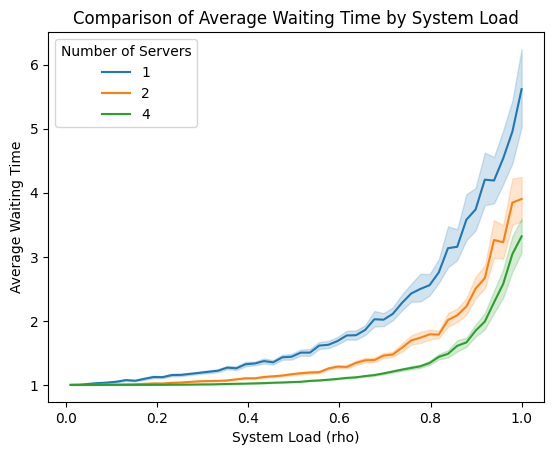

In [306]:
# 定义参数
SIM_TIME = 100
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 50)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


# Long tail distribution

In [309]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

def setup_tail(env, num_servers, Lambda, waiting_times):
    server = simpy.Resource(env, num_servers)

    def service(customer):
        # 随机选择服务时间分布
        if np.random.rand() < 0.75:  # 75%的情况，使用平均服务时间为1.0的指数分布
            yield env.timeout(np.random.exponential(1.0))
        else:  # 剩余25%的情况，使用平均服务时间为5.0的指数分布
            yield env.timeout(np.random.exponential(5.0))

    def customer(name):
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            waiting_times.append(waiting_time)
    
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

def run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    Lambda = rho * (MU * num_servers)
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_tail(env, num_servers, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [310]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          2.826625   
1             2  0.10          2.024172   
2             4  0.10          1.906278   
3             1  0.50          9.752172   
4             2  0.50          8.544119   
5             4  0.50          6.917301   
6             1  0.90         22.938702   
7             2  0.90         21.611045   
8             4  0.90         22.986785   
9             1  0.99         25.273102   
10            2  0.99         24.471430   
11            4  0.99         24.783250   

                                     all_waiting_time  \
0   [[0.1427458658210803, 2.8821630977428185, 4.87...   
1   [[1.0618276637038804, 1.334852071482274, 4.713...   
2   [[1.1727684467405743, 1.5037389716958112, 2.19...   
3   [[0.15314429812817432, 1.1280163479938605, 0.6...   
4   [[2.02727385236984, 2.9971946387381445, 0.5831...   
5   [[0.9458830817586059, 0.9440375061158608, 1.24...   
6   [[2.4931646782632066, 5.1985296645622

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


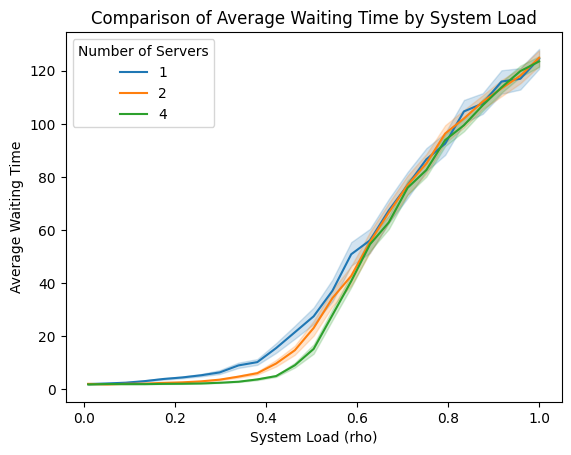

In [314]:
def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


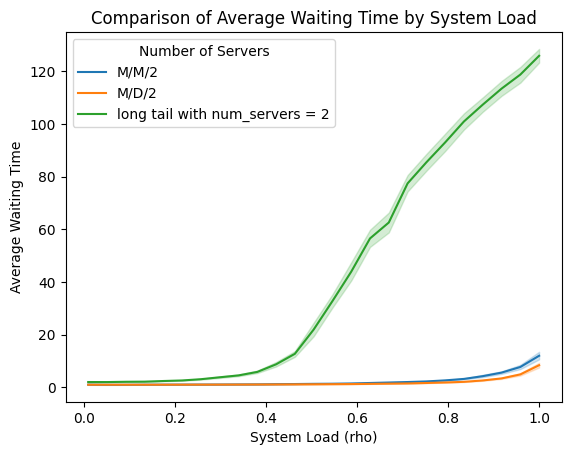

In [319]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/2", "M/D/2", "long tail with num_servers = 2"]  # 图片标签

simulation_results = []

num_servers = 2
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


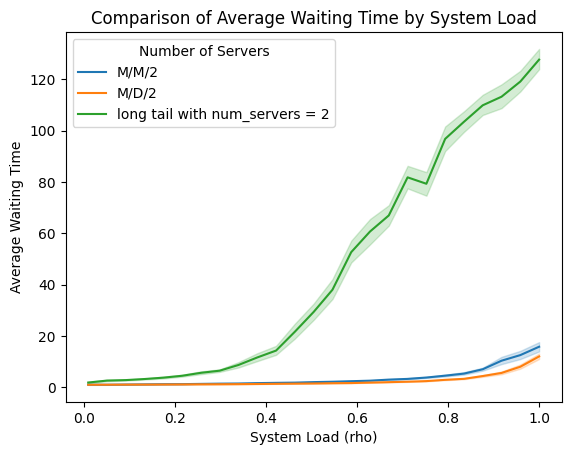

In [320]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/2", "M/D/2", "long tail with num_servers = 2"]  # 图片标签

simulation_results = []

num_servers = 1
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


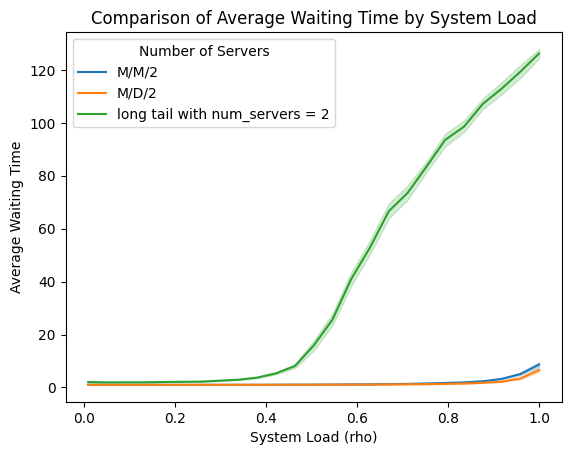

In [321]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/2", "M/D/2", "long tail with num_servers = 2"]  # 图片标签

simulation_results = []

num_servers = 4
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


### 不用的代码

In [ ]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

# 设置输出格式，以显示所有行和列
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 定义队列类
class Queue:
    def __init__(self, env, num_servers, servicetime):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.servicetime = servicetime

    def service(self, customer):
        """服务过程使用指数分布的服务时间"""
        yield self.env.timeout(np.random.exponential(self.servicetime))

# 定义顾客到达过程
def customer(env, name, qu):
    arrival_time = env.now
    with qu.server.request() as request:
        yield request
        yield env.process(qu.service(name))
        waiting_time = env.now - arrival_time
        # 记录每个顾客的等待时间
        qu.env.waiting_times.append(waiting_time)

# 初始化模拟环境和顾客到达过程
def setup(env, num_servers, servicetime, Lambda):
    queue = Queue(env, num_servers, servicetime)
    queue.env.waiting_times = []
    # 生成初始顾客
    env.process(customer(env, 'Customer 0', queue))
    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(env, f'Customer {env.now}', queue))

# 运行模拟函数
def run_simulation(num_servers, Lambda, servicetime, SIM_TIME, SIMULATIONS):
    data_sims = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        env.process(setup(env, num_servers, servicetime, Lambda))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(env.waiting_times)
        data_sims.append(avg_waiting)
    return data_sims

# 模拟参数
MU = 1  # the capacity of each of n equal servers
SIM_TIME = 100
SIMULATIONS = 100
SERVERS = [1, 2, 4]  # 服务器数量n
RHO = [0.5, 0.9, 0.99]  # the system load, RHO = Lambda / (MU * n)

# 存储所有模拟的结果
all_sim_data = []

# 对每个服务器数量n和系统负载ρ运行模拟
for num_servers in SERVERS:
    for rho in RHO:
        Lambda = rho * (MU * num_servers)  # the arrival rate into the system as a whole
        sim_data = run_simulation(num_servers, Lambda, 1/MU, SIM_TIME, SIMULATIONS)
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(sim_data),
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(sim_data), scale=stats.sem(sim_data))
        })

# 将结果转换为DataFrame并保存为CSV文件
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设all_sim_data已经根据上述代码生成并转换为DataFrame
df = pd.DataFrame(all_sim_data)

# 绘制每个ρ值和服务器数量的平均等待时间的概率密度函数
plt.figure(figsize=(12, 8))

for num_servers in SERVERS:
    subset = df[df['num_servers'] == num_servers]
    sns.kdeplot(subset['avg_waiting_time'], label=f'Servers: {num_servers}')

plt.title('Probability Density Function of Average Waiting Time')
plt.xlabel('Average Waiting Time')
plt.ylabel('Density')
plt.legend()
plt.show()